# Retinal Blood Vessel Segmentation
## 16725 Final Project by Hung-yu Chang

<b>Goal</b>: Vessel extraction from fundus images using SimpleItk.

In [163]:
# Import resources and display image
from __future__ import print_function
import matplotlib.pyplot as plt
import SimpleITK as sitk
from math import cos, sin, pi
%matplotlib inline


In [164]:
# Defining myshow function for image display
def myshow(img, title=None, margin=0.05, dpi=80 ):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    
    
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
   
    
    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

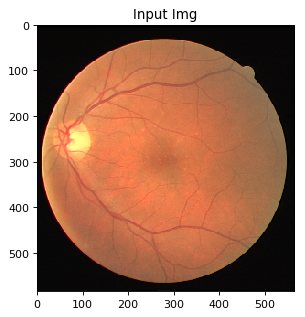

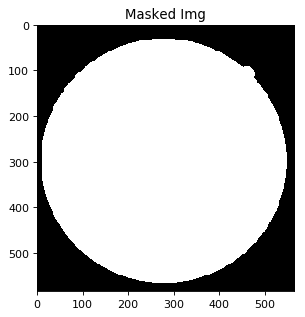

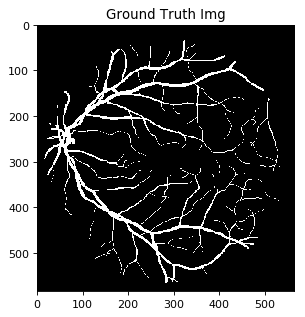

In [207]:
# Read the image 
img = sitk.ReadImage('images/21_training.tif')
myshow(sitk.Shrink(img,[2,2]),title='Input Img') # I Shink the image for easier view in a browser

# Read the mask and create a mask filter
maskImg = sitk.ReadImage("mask/21_training_mask.tif",sitk.sitkUInt8)
maskImg.SetSpacing([1,1])
myshow(sitk.Shrink(maskImg,[2,2]),title='Masked Img')
maskFilter = sitk.MaskImageFilter()
maskFilter.SetOutsideValue(0)

# Read the ground truth
GT_Img = sitk.ReadImage('1st_manual/21_manual1.tif')
GT_Img.SetSpacing([1,1])
myshow(sitk.Shrink(GT_Img,[2,2]),title='Ground Truth Img')


# Section I Preprocessing
## Step1. Split the channels of a fundus image
### Notes:
We can see that the green channel has a higher contrast. In the further step, I will segment the vessels from green channel images.

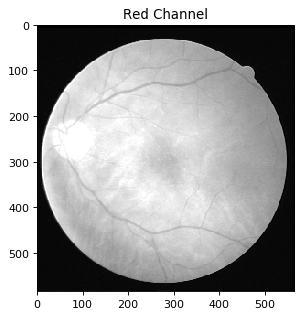

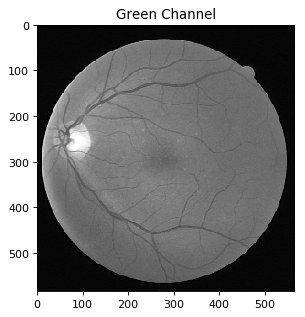

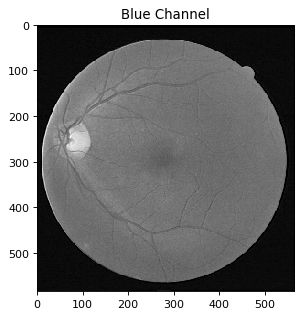

In [201]:
# Split RGB Channel
select = sitk.VectorIndexSelectionCastImageFilter()
Red_image = select.Execute(img, 0, sitk.sitkUInt16)
Green_image = select.Execute(img, 1, sitk.sitkUInt16)
Blue_image = select.Execute(img, 2, sitk.sitkUInt16)
myshow(sitk.Shrink(Red_image,[2,2]),title='Red Channel')
myshow(sitk.Shrink(Green_image,[2,2]),title='Green Channel')
myshow(sitk.Shrink(Blue_image,[2,2]),title='Blue Channel')


## Step2. Enhance the contrast of a fundus image
### Notes:
Here I used the adaptive histogram equlization image filter to enhance the contrast of the vessel image

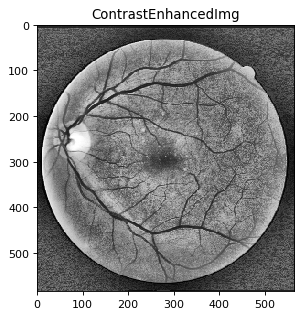

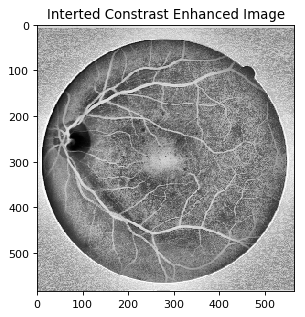

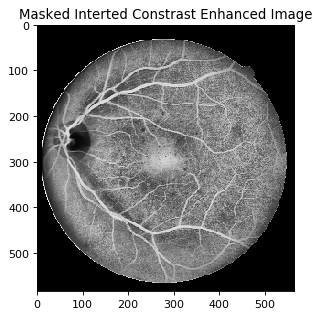

In [341]:
# Histogram equalization
HistogramEqualizer = sitk.AdaptiveHistogramEqualizationImageFilter()
HistogramEqualizer.SetRadius(50)
ContrastEnhancedImg = HistogramEqualizer.Execute(Green_image)
ContrastEnhancedImg = sitk.Cast(ContrastEnhancedImg, sitk.sitkFloat32)
myshow(sitk.Shrink(ContrastEnhancedImg,[2,2]),title='ContrastEnhancedImg')

InvertFilter = sitk.InvertIntensityImageFilter()
InvertedContrastEnhancedImg = InvertFilter.Execute(ContrastEnhancedImg)
myshow(sitk.Shrink(InvertedContrastEnhancedImg,[2,2]),title = 'Interted Constrast Enhanced Image')

maskImg = sitk.ReadImage("mask/21_training_mask.tif",sitk.sitkUInt8)
maskImg.SetSpacing([1,1])
EnhancedImg_masked = maskFilter.Execute(InvertedContrastEnhancedImg,maskImg)
myshow(sitk.Shrink(EnhancedImg_masked,[2,2]),title = 'Masked Interted Constrast Enhanced Image')

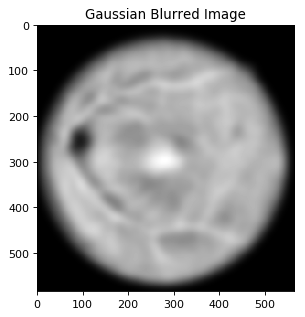

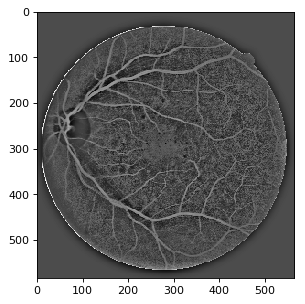

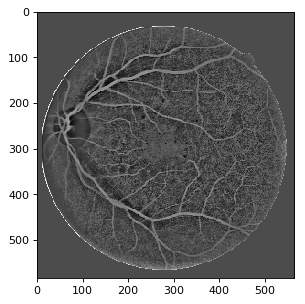

In [342]:
# Gaussian blurred Image
blurFilter = sitk.DiscreteGaussianImageFilter()
blurFilter.SetVariance(100)
blurredImg = blurFilter.Execute(EnhancedImg_masked)
blurredImg = sitk.Cast(blurredImg, sitk.sitkFloat32)
myshow(sitk.Shrink(blurredImg,[2,2]), title = 'Gaussian Blurred Image')

# Subtract Background
BackgroundRemovedImg = EnhancedImg_masked-blurredImg
myshow(sitk.Shrink(BackgroundRemovedImg,[2,2]))


MaskedBackgroundRemovedImg = maskFilter.Execute(BackgroundRemovedImg,maskImg)
myshow(sitk.Shrink(MaskedBackgroundRemovedImg,[2,2]))

# Section II Convolve with Gabor Filter Banks
Here I follow the method used by <a href="https://ieeexplore.ieee.org/abstract/document/6830527">Farnaz Farokhian _et. al._</a>. Here, I'll try to use 180 gabor filters with different angle using <b>sitk.GaborImageSource()</b>.

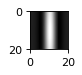

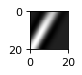

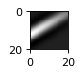

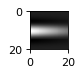

In [291]:
# Create Gabor filter banks
GaborFilterList = []
gaborimage = sitk.GaborImageSource()
gaborimage.SetSize([20, 20])
gaborimage.SetSigma([3,20])
gaborimage.SetMean([10,10])
gaborimage.SetFrequency(0.07)

for i in range(91):
    gaborimage.SetDirection([cos(pi*i/180), sin(pi*i/180), -sin(pi*i/180), cos(pi*i/180)])
    gaborfilter = gaborimage.Execute()
    GaborFilterList.append(gaborfilter)

Flipfilter = sitk.FlipImageFilter() 
Flipfilter.SetFlipAxes([True,False])

# Create another half using Flipfilter
for i in range(91):
    gaborfilter = Flipfilter.Execute(GaborFilterList[i])
    GaborFilterList.append(gaborfilter)

# Output some gaboar source example
myshow(sitk.Expand(GaborFilterList[0],[2,2]))
myshow(sitk.Expand(GaborFilterList[30],[2,2]))
myshow(sitk.Expand(GaborFilterList[60],[2,2]))
myshow(sitk.Expand(GaborFilterList[90],[2,2]))


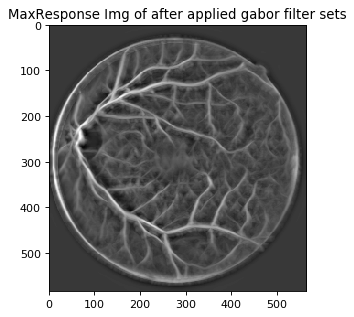

In [344]:
# Convolution with gabor filter banks
Conv = sitk.ConvolutionImageFilter()
ConvolvedImgList = []
for i in GaborFilterList:
    ConvolvedImgList.append(Conv.Execute(BackgroundRemovedImg, i))

    
# Aquired the max pixels from the convlvedImgList
Maxfilter = sitk.MaximumImageFilter()
MaxResponse = Maxfilter.Execute(ConvolvedImgList[0], ConvolvedImgList[1])
for i in ConvolvedImgList[2:]:
    MaxResponse = Maxfilter.Execute(MaxResponse, i)

myshow(sitk.Shrink(MaxResponse,[2,2]),title ='MaxResponse Img of after applied gabor filter sets')

    

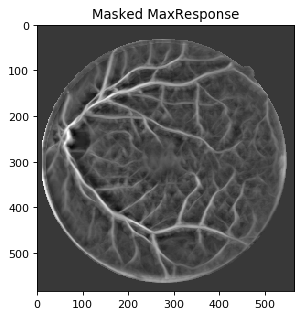

In [346]:
maskImg = sitk.ReadImage("mask/21_training_mask.tif",sitk.sitkUInt8)
maskImg.SetSpacing([1,1])
MaxResponse_masked = maskFilter.Execute(MaxResponse,maskImg)
myshow(sitk.Shrink(MaxResponse_masked,[2,2]),title ='Masked MaxResponse')



# Section III Post Porcessing
In this section, I use my best trial and error combination of post processing method to get a good result.The filters I used including, <b>BlackTopHatImageFilter, Dilation, Opening, Closing</b>

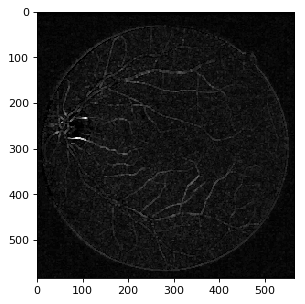

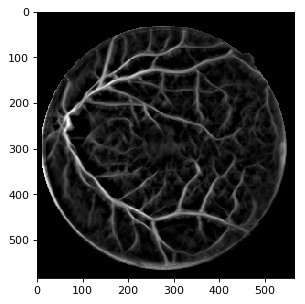

In [347]:
# BlackTopHat
TopHatFilter= sitk.BlackTopHatImageFilter()
TopHatImg = TopHatFilter.Execute(Green_image)
TopHatImg = sitk.Cast(TopHatImg, sitk.sitkFloat32)

# Dilate TopHat
DilateFilter = sitk.GrayscaleDilateImageFilter()
TopHatImg = DilateFilter.Execute(TopHatImg)
myshow(sitk.Shrink(TopHatImg,[2,2]))


# MaxResponse of TopHat and Gaborfilter
MaxResponse_and_TopHat = Maxfilter.Execute(MaxResponse_masked, TopHatImg)
myshow(sitk.Shrink(MaxResponse_and_TopHat,[2,2]))



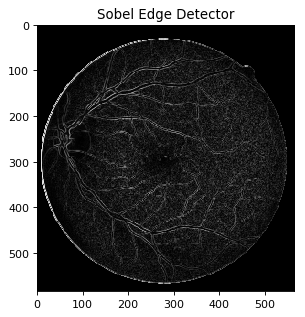

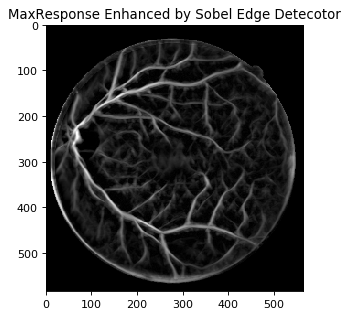

In [350]:
# Sobel Edge Detector
SobelFilter = sitk.SobelEdgeDetectionImageFilter()
SobelImg =SobelFilter.Execute(MaskedBackgroundRemovedImg)
myshow(sitk.Shrink(SobelImg,[2,2]),title = 'Sobel Edge Detector')

# Combined Sobel Edge Detector with MaxResponse_and_TopHat
MaxResponse_Sobel = Maxfilter.Execute(MaxResponse_and_TopHat, SobelImg)
myshow(sitk.Shrink(MaxResponse_Sobel,[2,2]),title='MaxResponse Enhanced by Sobel Edge Detecotor')



In [390]:
# Get the statistics of MaxResponse_Sobel Image
stat = sitk.StatisticsImageFilter()
stat.Execute(MaxResponse_Sobel)
print(stat.GetMean())
print(stat.GetSigma())
print(stat.GetMinimum())
print(stat.GetMaximum())

599.367680457223
825.6124348973883
0.0
6358.4912109375


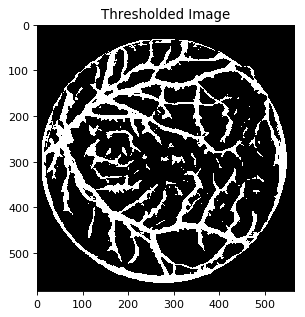

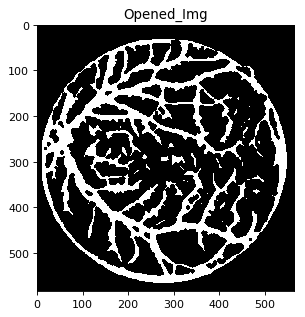

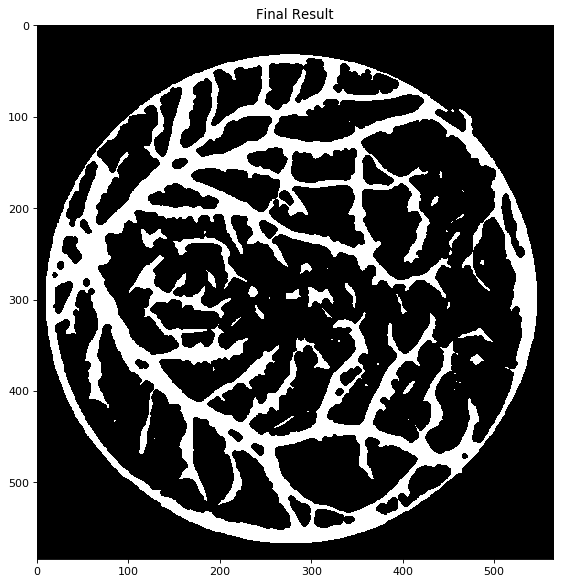

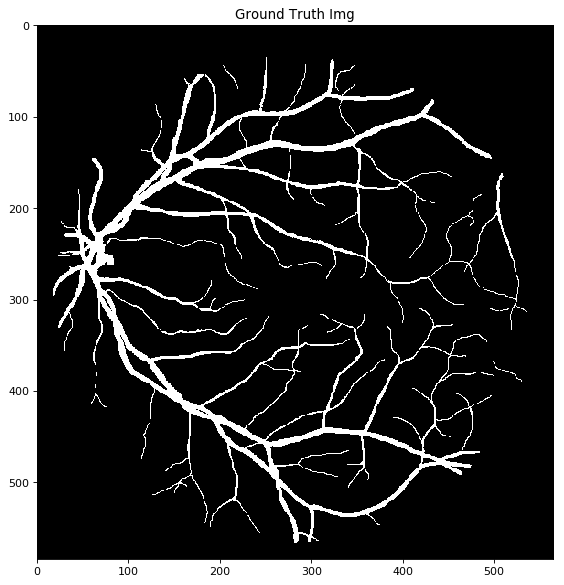

In [381]:
# Setup Thresholder
Thresholder = sitk.BinaryThresholdImageFilter()
Thresholder.SetInsideValue(1)
Thresholder.SetOutsideValue(0)

# Here I set Mean+1*Standard Error as lower thereshold 
# And
Thresholder.SetUpperThreshold(stat.GetMaximum())
Thresholder.SetLowerThreshold(stat.GetMean()+0.5*stat.GetSigma()) 
ThresholdedImg = Thresholder.Execute(MaxResponse_Sobel)
myshow(sitk.Shrink(ThresholdedImg,[2,2]),title = 'Thresholded Image')




# Do one Opening and one Closing to smooth the image
OpeningFilter = sitk.GrayscaleMorphologicalOpeningImageFilter()
OpeningFilter.SetKernelRadius(3)
Opened_Img = ClosingFilter.Execute(ThresholdedImg)
myshow(sitk.Shrink(Closed_Img,[2,2]),title = 'Opened_Img')

ClosingFilter = sitk.GrayscaleMorphologicalClosingImageFilter()
ClosingFilter.SetKernelRadius(3)
Closed_Img = ClosingFilter.Execute(Opened_Img)
myshow(sitk.Shrink(Closed_Img,[1,1]),title = 'Final Result')

# Ground Truth
myshow(sitk.Shrink(GT_Img,[1,1]),title='Ground Truth Img')

# Discussion and thoughts

### 1. My result is thicker than the ground truth and preliminary result
If you go back to check my slide, my preliminary result's thickness is much more similar to the ground truth. However, my previous segmentation (<i>without using gabor filters bank</i>) is more like a dotted lines, the vessels are not connected.

As you can see my final result is thicker than the ground truth. I think the most important factor is after the thresholding step. I did not use <b>region growing</b>, because I wanted to try an auto segmentation method. If use region growing method, we need to manually pick seed points. Unfortunately, SimpleItk does not provide local threshold method(adaptive threshold). So here I just use the <b>BinaryThresholdImageFilter</b>. But if we can have adaptive threshold method, the result would be better.

### 2. Background subtraction can negate some false positive effect created by optical disk region
The optic disc region in a fundus image has a highest intensity. It usally caused problem when we try to segment the vessels. Here, I use <b>Guassan blurred</b> image as background. In section I step 2, you can see how I removed the background of opitc disk

### 3. My segmentation is not smooth
After applied gabor filters to the image, I found there are some semicircular/triangular noises beside the vessel wall. I believe these are the artifacts of gabor filters. I think I need to finetune the gabor source to avoid these unwanted noises.

### 4. Future work
My futrue work will focusing on followin area:
1. Analyze the segmentation accuracy comparing to ground truth.
2. Analyze the morphological attributes of vessels such as branch points.
3. Feed data into machine learning models to see if my segmentation method help the classification process.


